# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Guirec Maloisel"
student2 = "Adrian Valente"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
#subset_of_classes = np.random.choice(range(10), 5, replace = False)
subset_of_classes = np.array([0,1,5,8,6])
#We hardcoded the subset of classes to cope with the randomness issue, and then didn't have time to re-run everything again 
#with the sciper numbers

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
subset_of_classes

array([0, 1, 5, 8, 6])

### Plotting

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [5]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [6]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

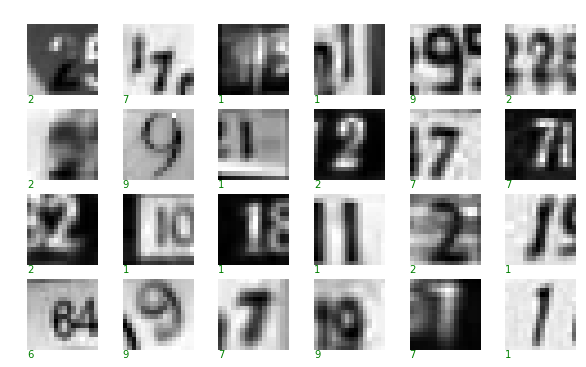

In [7]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Definition of some useful functions

In [9]:
def earlyStopping(history, min_delta=0, patience=0):
    """
    Returns the index at which we should have stopped to get the best loss
    NB : Not used in practise, we found more convenient to just take the minimal validation loss
    """
    nb_non_decrease = 0
    delta = abs(min_delta)
    n_epochs = len(history.history['loss'])
    current_min = history.history['val_loss'][0]
    for i in range(1, n_epochs):
        if(history.history['val_loss'][i] > current_min - delta):
            nb_non_decrease += 1
            if(nb_non_decrease > patience):
                return i - patience
        else:
            current_min = history.history['val_loss'][i]
            nb_non_decrease = 0
    return i


def bestValidationScore(history, min_delta=0, patience=0):
    """
    Returns a tuple (val_loss, val_acc) corresponding to the best validation loss
    """
    i = np.nanargmin(history.history['val_loss'])
    return (history.history['val_loss'][i], history.history['val_acc'][i])

def plot_misclassified_samples(model, x_test, y_test):
    """
    Plots some of the misclassified samples
    """
    yhat_test = model.predict(x_test)
    error_indices = np.where(np.argmax(y_test, axis=1) != np.argmax(yhat_test, axis=1))[0]
    plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping=subset_of_classes)

In [10]:
import sys

standard_stdout = sys.stdout

def fit_model(model, x_train, y_train, **kwargs):
    """
    Fits the model while redirecting the verbose output to a log file (to check progress without polluting the notebook):
    (taken from https://stackoverflow.com/questions/34145950/is-there-a-way-to-redirect-stderr-to-file-in-jupyter)
    """
    file = open('logtrain.txt', 'w')
    sys.stdout = file
    history = model.fit(x_train, y_train, **kwargs)
    sys.stdout.flush()
    sys.stdout = standard_stdout
    return history

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________
(1.4906093940330616, 0.369768852348541)


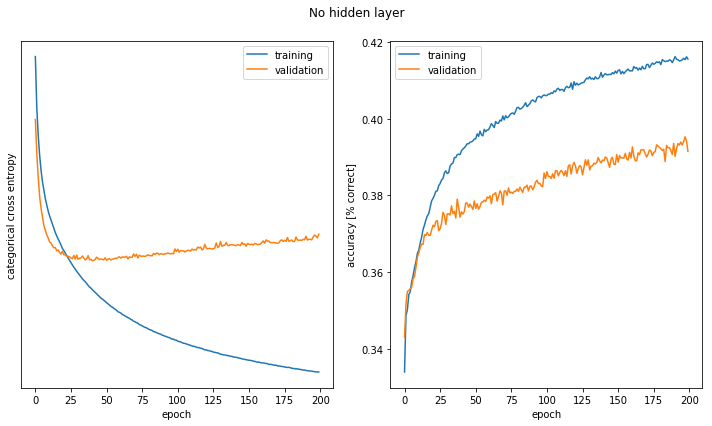

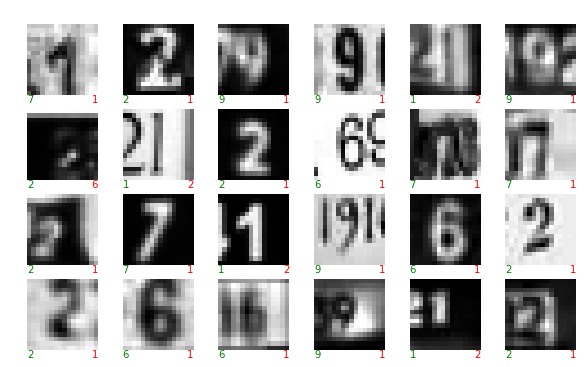

In [13]:
model = Sequential()
model.add(Dense(5, activation='softmax', input_shape=(256,)))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.summary()

history = fit_model(model, x_train, y_train, 
          batch_size=128, epochs=200, validation_data=(x_test, y_test),  verbose=1)

score = bestValidationScore(history)

print(score)
plot_history(history, "No hidden layer")
plot_misclassified_samples(model, x_test, y_test)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [20]:
def build_model_ex2(optimizer, lr=None):
    model = Sequential()   
    model.add(Dense(64, input_dim=256, activation='relu', name="H1"))
    model.add(Dense(5, activation='sigmoid', name = 'Y'))  
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    model.summary()
    if lr is not None:
        model.optimizer.lr = lr   
    return model

def test_model_ex2(optimizer, lr=None, title=""):
    model = build_model_ex2(optimizer, lr)
    history = fit_model(model, x_train, y_train, epochs=50, verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test)
    print("Validation Loss: ", score[0])
    print("Validation accuracy: ", score[1])
    plot_history(history, title=title)
    return history

### Tests with SGD

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  1.4572739882308186
Validation accuracy:  0.34422804771210996


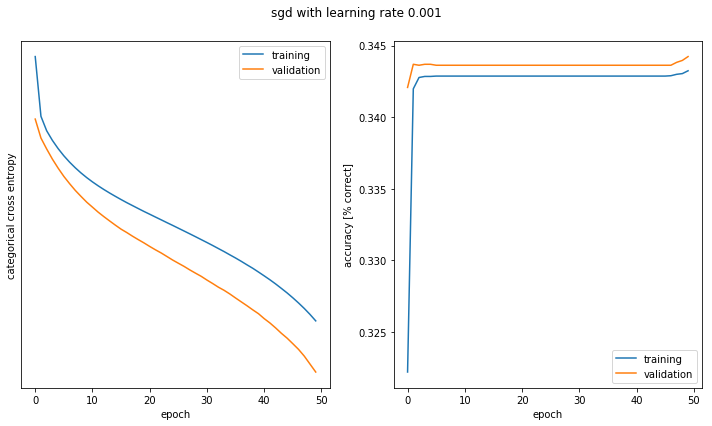

In [11]:
histories = []

lr = 0.001
optimizer = 'sgd'

histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.621447727621401
Validation accuracy:  0.8183165981575311


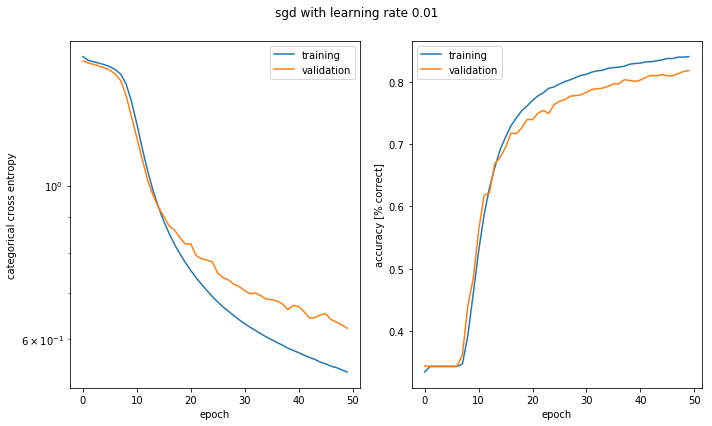

In [12]:
lr = 0.01
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.48101600376982373
Validation accuracy:  0.8710155670425466


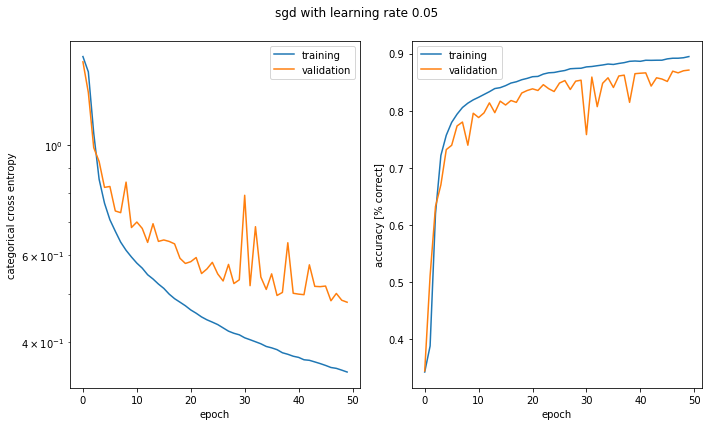

In [13]:
lr = 0.05
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.48595657574936857
Validation accuracy:  0.8707460070991542


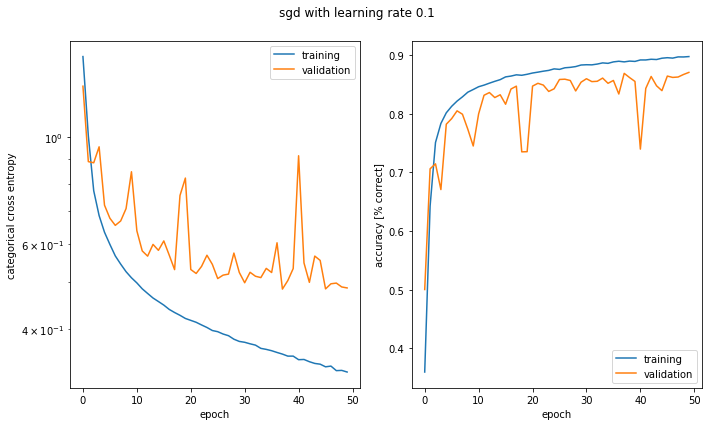

In [15]:
lr = 0.1
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 15us/step
Validation Loss:  0.5436738602768355
Validation accuracy:  0.8619179189530527


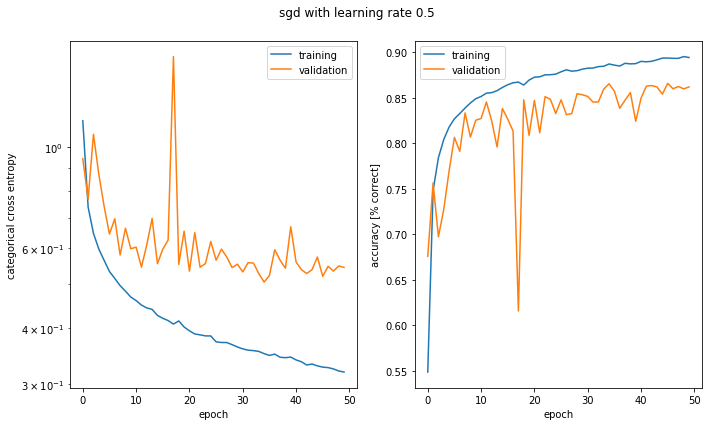

In [16]:
lr = 0.5
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 15us/step
Validation Loss:  0.6739748262782264
Validation accuracy:  0.8336815148987645


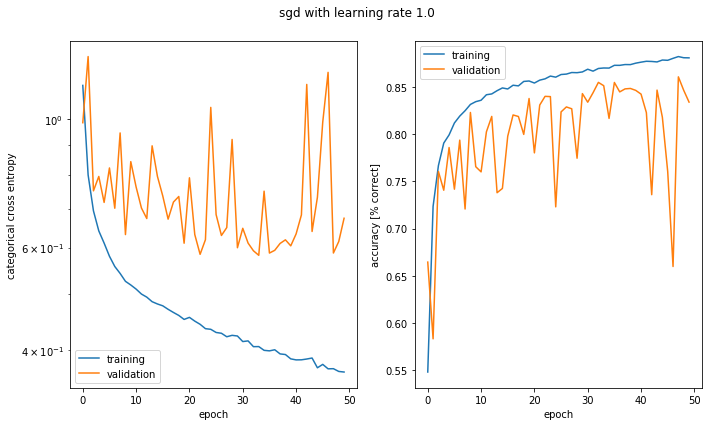

In [17]:
lr = 1.0
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 15us/step
Validation Loss:  0.787434251990165
Validation accuracy:  0.8052429408547981


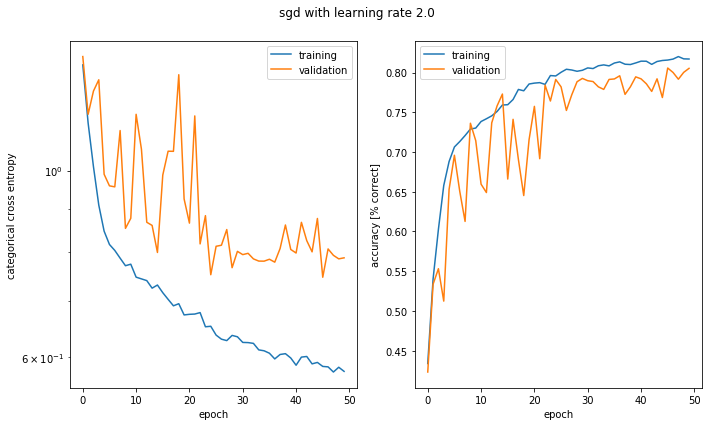

In [18]:
lr = 2.0
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) Convergence is at first very fast, but then we oscillate around the optimum. Model variance is also higher.

B) Convergence is very slow. For the smallest learning rate tested we even get stuck on a plateau.

### Comparison of SGD and Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.5067659236204031
Validation accuracy:  0.8724981468075232


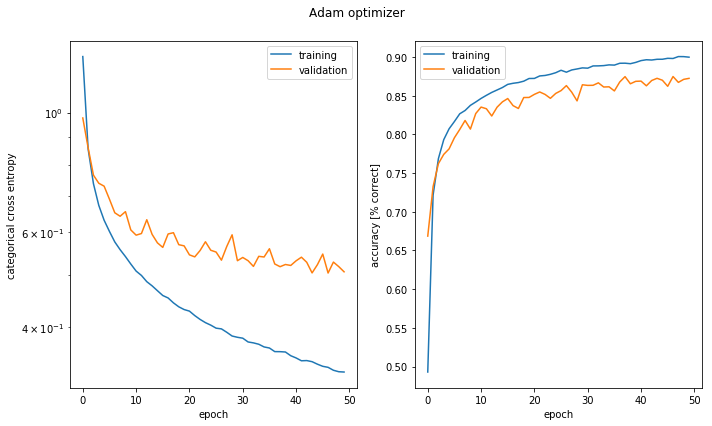

In [21]:
optimizer = 'adam'

histories.append(test_model_ex2(optimizer, title="Adam optimizer"))

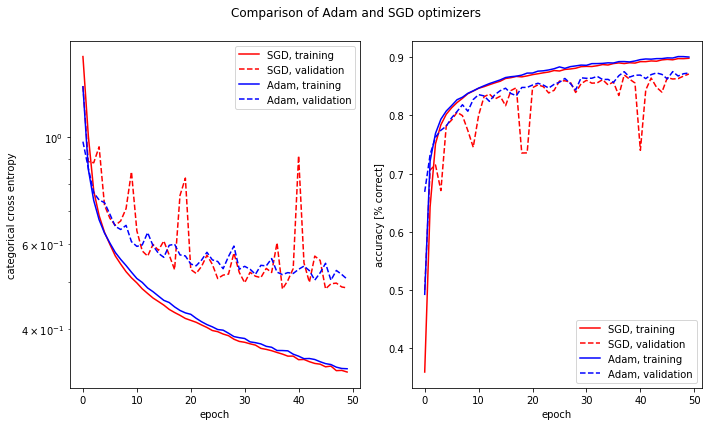

In [27]:
history_sgd = histories[3]
history_adam = histories[7]

fig, ax1, ax2 = prepare_standardplot("Comparison of Adam and SGD optimizers", 'epoch')
ax1.plot(history_sgd.history['loss'], label = "SGD, training", c='r')
ax1.plot(history_sgd.history['val_loss'], label = "SGD, validation", c='r', linestyle='--')
ax1.plot(history_adam.history['loss'], label = "Adam, training", c='b')
ax1.plot(history_adam.history['val_loss'], label = "Adam, validation", c='b', linestyle='--')
ax2.plot(history_sgd.history['acc'], label = "SGD, training", c='r')
ax2.plot(history_sgd.history['val_acc'], label = "SGD, validation", c='r', linestyle='--')
ax2.plot(history_adam.history['acc'], label = "Adam, training", c='b')
ax2.plot(history_adam.history['val_acc'], label = "Adam, validation", c='b', linestyle='--')
finalize_standardplot(fig, ax1, ax2)

The result reached if we wait for enough epochs is the same with both optimizers ; however convergence is more stable with Adam optimizer. If for instance we did early stopping on the SGD results we would stop too early because of the peaks.

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


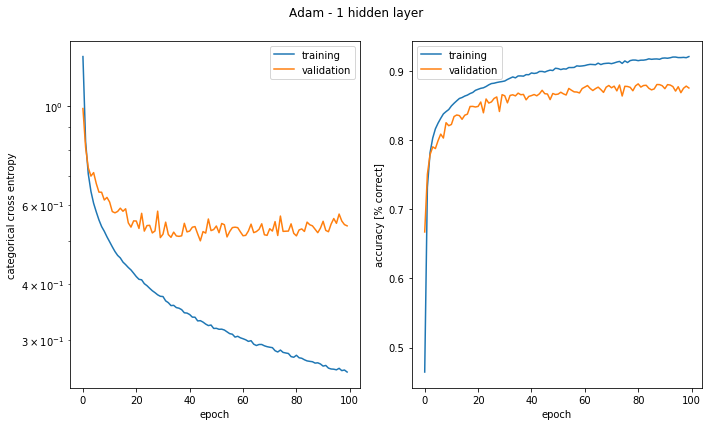

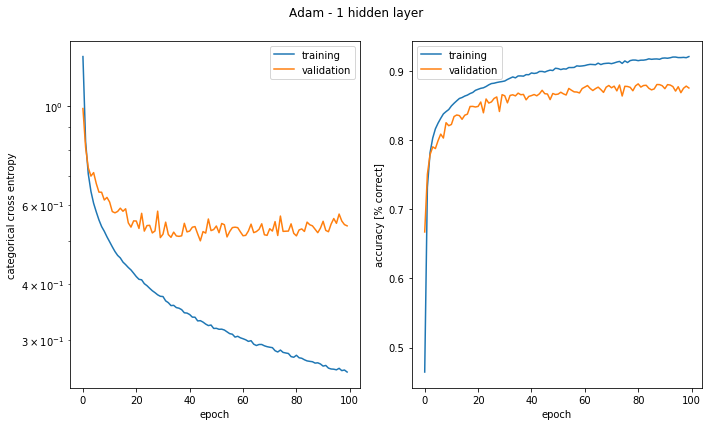

In [10]:
model = Sequential()
model.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model.add(Dense(5, activation='sigmoid', name = 'Y'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

history = fit_model(model, x_train, y_train, epochs=100, verbose=1, validation_data = (x_test, y_test))
plot_history(history, title="Adam - 1 hidden layer")

In [11]:
score = bestValidationScore(history)
print("Validation loss: ", score[0])
print("Accuracy loss: ", score[1])

Validation loss:  0.4997159740265927
Accuracy loss:  0.8727003166887491


**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: After 30-40 epochs, we can see overfitting, as the validation loss stops decreasing (and even starts increasing slightly). It is difficult however to be precise because of the noise in the validation loss.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: The validation loss eventually increases, while the validation accuracy at worst stays the same but doesn't decrease. This can be due to the fact that the misclassified samples always have the same impact on the accuracy, but can cause a bigger cross-entropy as the model overfits.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [18]:
from keras.callbacks import TerminateOnNaN, History

def build_model_ex4(n_neurons):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=256, activation='relu', name="H1"))
    model.add(Dense(5, activation='sigmoid', name = 'Y'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

def test_model_ex4(n_neurons, repetitions):
    histories = []
    final_losses = []
    ES_losses = []
    final_accs = []
    ES_accs = []
    
    for i in range(repetitions):
        #Train model
        model = build_model_ex4(n_neurons)
        histories.append(fit_model(model, x_train, y_train, epochs=100, verbose=1, validation_data=(x_test, y_test),
                                  callbacks=[TerminateOnNaN()]))
        final_score = model.evaluate(x_test, y_test)
        
        #Deal with nans
        if np.isnan(final_score[0]):
            lasti = np.where(np.isfinite(histories[-1].history['val_loss']))[0][-1]
            final_losses.append(histories[-1].history['val_loss'][lasti])
            final_accs.append(histories[-1].history['val_acc'][lasti])
        else:
            final_losses.append(final_score[0])
            final_accs.append(final_score[1])
        ES_score = bestValidationScore(histories[-1])
        ES_losses.append(ES_score[0])
        ES_accs.append(ES_score[1])
        
    #Create smoothed training curves (by taking the mean of histories)
    hist = History()
    hist.history = {'loss': np.mean([h.history['loss'] for h in histories], axis=0),
            'val_loss': np.mean([h.history['val_loss'] for h in histories], axis=0),
            'acc': np.mean([h.history['acc'] for h in histories], axis=0),
            'val_acc': np.mean([h.history['val_acc'] for h in histories], axis=0)}
    plot_history(hist, title=str(n_neurons)+" hidden neurons")
    return final_losses, final_accs, ES_losses, ES_accs, histories

14839/14839 [==============================] - 0s 32us/step


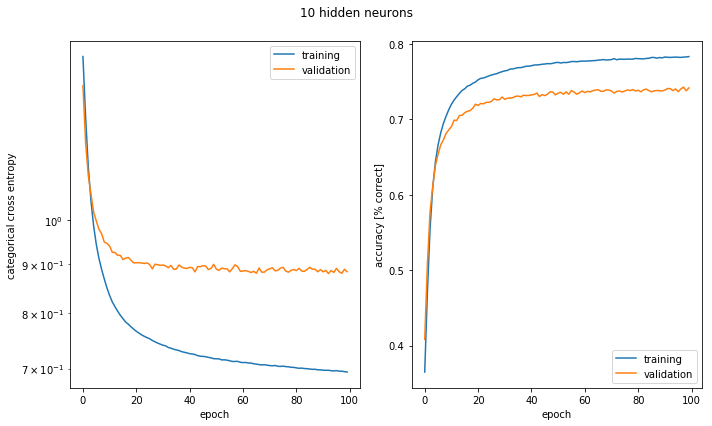

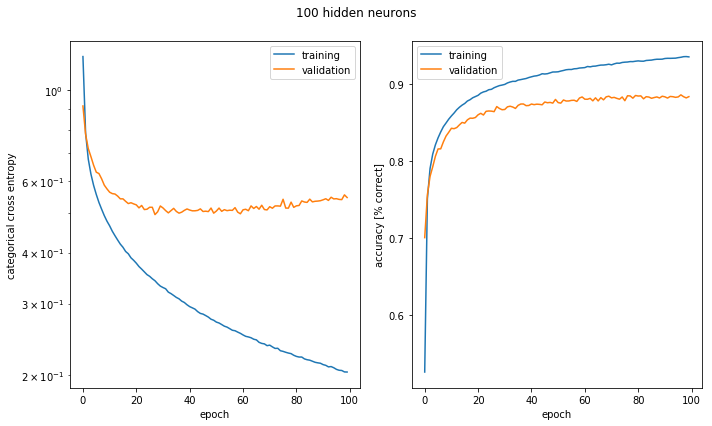

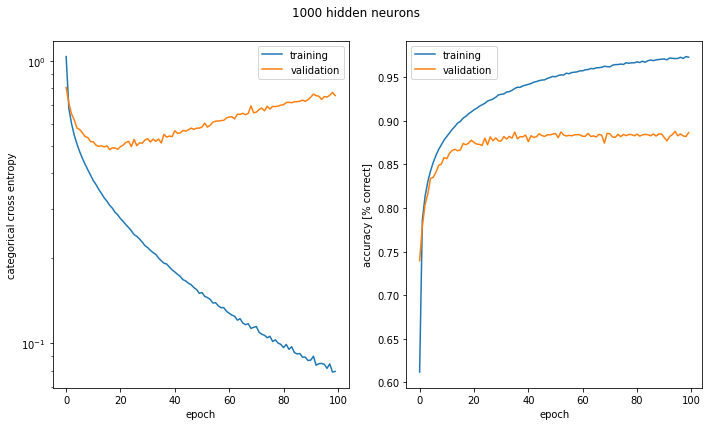

In [19]:
final_losses = []
ES_losses = []
final_accs = []
ES_accs = []
for n in (10, 100, 1000):
    fl, fa, el, ea, _ = test_model_ex4(n, 5)
    final_losses.append(fl)
    final_accs.append(fa)
    ES_losses.append(el)
    ES_accs.append(ea)
#NB: first output lines due to I/O bugs 

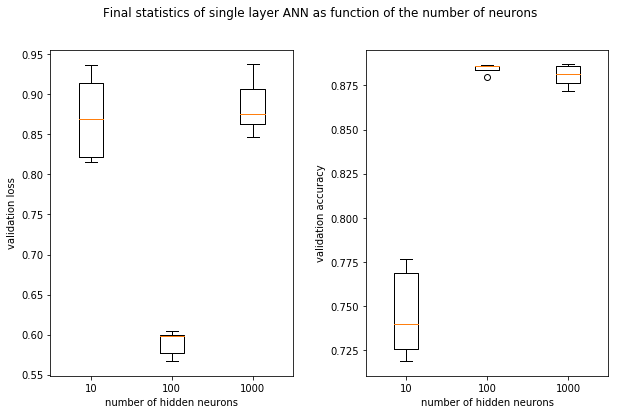

In [64]:
plt.figure()
ax = plt.subplot(121)
ax.boxplot(final_losses, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation loss")
ax = plt.subplot(122)
ax.boxplot(final_accs, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation accuracy")
plt.suptitle("Final statistics of single layer ANN as function of the number of neurons")
plt.subplots_adjust(wspace=0.3)
plt.show()

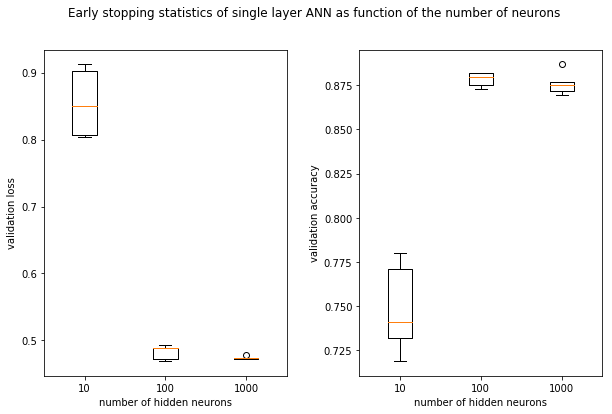

In [65]:
plt.figure()
ax = plt.subplot(121)
ax.boxplot(ES_losses, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation loss")
ax = plt.subplot(122)
ax.boxplot(ES_accs, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation accuracy")
plt.suptitle("Early stopping statistics of single layer ANN as function of the number of neurons")
plt.subplots_adjust(wspace=0.3)
plt.show()

One can notice on the previous figure that the best model is not the one with the most parameters, but the one with an intermediary number of parameters. The model with 10 hidden neurons underfits the data (given the final score). To the contrary the model with 1000 neurons is clearly overfitting, which can be seen on the training curve (the validation loss begins to increase very early with a high slope). Thus 100 neurons seems to be a good tradeoff.

In [ ]:
ES_accs_1 = ES_accs[1]
ES_losses_1 = ES_losses[1]
#For re-use in next exercise

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [69]:
def nb_parameters(N_in, K, N_h, N_out):
    """
    Returns the number of parameter to train given the network dimensions
    NB : Was used to validate our formulas
    """
    if K <= 0:
        return (N_in + 1) * N_out
    tot = (N_in + 1) * N_h
    tot += (K - 1) * (N_h + 1) * N_h
    tot += (N_h + 1) * N_out
    return tot

In [20]:
def ideal_N_h(N_in, K, N_h_1L, N_out):
    """
    Returns the value of N_h that best approximates the number of parameters obtained for a 1-hidden-layer network with 
    the same dimensions (computed by solving separately a quadratic equation using the formula implemented in nb_parameters)
    """
    if K <= 0:
        return 0
    temp = N_in + K + N_out
    res = (-temp + np.sqrt(temp*temp + 4 * (K-1) * N_h_1L * (N_in + N_out + 1))) / (2 * (K - 1))
    return int(round(res))

In [72]:
def build_model_ex5(N_in, K, N_h, N_out):
    model = Sequential()
    if K <= 0:
        model.add(Dense(N_out, input_dim = N_in, activation='sigmoid', name = 'Y'))
    else:
        model.add(Dense(N_h, input_dim = N_in, activation = 'relu', name = 'H1'))
        for k in range(2, K + 1):
            model.add(Dense(N_h, activation='relu', name='H{}'.format(k)))
        model.add(Dense(N_out, activation='sigmoid', name='Y'))
    return model

In [80]:
def test_K_layers(K):
    N_in, N_h_1L, N_out = 256, 100, 5
    N_h = ideal_N_h(N_in, K, N_h_1L, N_out)
    histories = []
    for i in range(5):
        model = build_model_ex5(N_in, K, N_h, N_out)
        if (i==0):
            model.summary()
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        histories.append(fit_model(model, x_train, y_train, epochs=100, verbose=1, validation_data=(x_test, y_test)))
    return histories

In [81]:
histories_2 = test_K_layers(2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 77)                19789     
_________________________________________________________________
H2 (Dense)                   (None, 77)                6006      
_________________________________________________________________
Y (Dense)                    (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________


In [82]:
histories_3 = test_K_layers(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 66)                16962     
_________________________________________________________________
H2 (Dense)                   (None, 66)                4422      
_________________________________________________________________
H3 (Dense)                   (None, 66)                4422      
_________________________________________________________________
Y (Dense)                    (None, 5)                 335       
Total params: 26,141
Trainable params: 26,141
Non-trainable params: 0
_________________________________________________________________


In [83]:
histories_4 = test_K_layers(4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 59)                15163     
_________________________________________________________________
H2 (Dense)                   (None, 59)                3540      
_________________________________________________________________
H3 (Dense)                   (None, 59)                3540      
_________________________________________________________________
H4 (Dense)                   (None, 59)                3540      
_________________________________________________________________
Y (Dense)                    (None, 5)                 300       
Total params: 26,083
Trainable params: 26,083
Non-trainable params: 0
_________________________________________________________________


In [ ]:
losses, accuracies = [], []

losses.append(ES_losses_1)
accuracies.append(ES_accs_1)

losses_2, accuracies_2 = [], []
for histo in histories_2:
    score = bestValidationScore(histo)
    losses_2.append(score[0])
    accuracies_2.append(score[1])
losses.append(losses_2)
accuracies.append(accuracies_2)

losses_3, accuracies_3 = [], []
for histo in histories_3:
    score = bestValidationScore(histo)
    losses_3.append(score[0])
    accuracies_3.append(score[1])
losses.append(losses_3)
accuracies.append(accuracies_3)

losses_4, accuracies_4 = [], []
for histo in histories_4:
    score = bestValidationScore(histo)
    losses_4.append(score[0])
    accuracies_4.append(score[1])
losses.append(losses_4)
accuracies.append(accuracies_4)

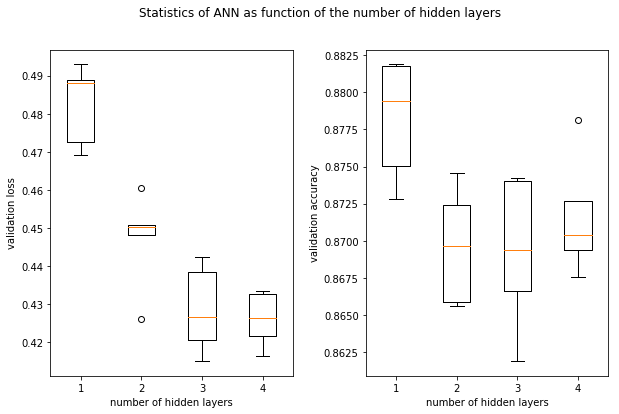

In [85]:
plt.figure()
ax = plt.subplot(121)
ax.boxplot(losses, labels=['1', '2', '3', '4'])
ax.set_xlabel("number of hidden layers")
ax.set_ylabel("validation loss")
ax = plt.subplot(122)
ax.boxplot(accuracies, labels=['1', '2', '3', '4'])
ax.set_xlabel("number of hidden layers")
ax.set_ylabel("validation accuracy")
plt.suptitle("Statistics of ANN as function of the number of hidden layers")
plt.subplots_adjust(wspace=0.3)
plt.show()

We can observe that, surprisingly, adding more layers to our network allows to decrease validation loss (and even variance), but leads to worse accuracy. We find these results difficult to interpret, the only thing it seems to highlight is that the loss does not characterize well enough the accuracy (as best loss does not imply best accuracy). It may be that we need to add regularization to our models with several hidden layers, to compensate the added flexibility.

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

We first tried to find the best parameters for each type of trick separately (dropout, batch normalization and l1 or l2 regularization) ; we didn't include all these tests in this notebook. Then we compared all the promising models at the same time, doing several runs for each to also capture model variance. The testing methods and results are as follows :

In [75]:
from keras.callbacks import History

nepochs = 100

def save_hist(hist, filename):
    with open(filename, 'w') as f:
        f.write(str(hist.history["acc"]))
        f.write(str(hist.history["loss"]))
        f.write(str(hist.history["val_acc"]))
        f.write(str(hist.history["val_loss"]))

def mean_hist(histories):
    hist = History()
    hist.history = {'loss': np.mean([h.history['loss'] for h in histories], axis=0),
            'val_loss': np.mean([h.history['val_loss'] for h in histories], axis=0),
            'acc': np.mean([h.history['acc'] for h in histories], axis=0),
            'val_acc': np.mean([h.history['val_acc'] for h in histories], axis=0)}
    return hist

def test_model(model, name, histories, losses, accuracies):
    print("### "+name+" ###")
    losses[name] = []
    accuracies[name] = []
    histos = []
    for i in range(5):
        if i==0:
            model.summary()
        hist = fit_model(model, x_train, y_train, epochs=nepochs, verbose=1, validation_data=(x_test, y_test))
        score = bestValidationScore(hist)
        losses[name].append(score[0])
        accuracies[name].append(score[1])
        histos.append(hist)
    histories[name] = mean_hist(histos)
    save_hist(histories[name], name+".hist")
    print("Validation loss: {:.3f} ± {:.3f}".format(np.mean(losses[name]), np.std(losses[name])))
    print("Accuracy: {:.3f} ± {:.3f}".format(np.mean(accuracies[name]), np.std(accuracies[name])))
    print("\n\n")
    
def print_results(histories, losses, accuracies):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(121)
    ax.boxplot(losses.values(), labels=losses.keys())
    ax.set_xlabel("number of hidden layers")
    ax.set_ylabel("validation loss")
    ax = plt.subplot(122)
    ax.boxplot(accuracies.values(), labels=accuracies.keys())
    ax.set_xlabel("number of hidden layers")
    ax.set_ylabel("validation accuracy")
    plt.suptitle("Different tricks")
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    
    plt.figure()
    i = 0
    fig, ax1, ax2 = prepare_standardplot("Comparison of different tricks", 'epoch')
    for k in histories.keys():
        h = histories[k].history
        ax1.plot(h["val_loss"], color='C'+str(i), label=k)
        ax2.plot(h["val_acc"], color='C'+str(i), label=k)
        i += 1
    finalize_standardplot(fig, ax1, ax2)

#### 1 hidden layer

In [55]:
histories = {}
losses = {}
accuracies = {}

#Baseline
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,)))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, 'baseline', histories, losses, accuracies)

# Dropout on the hidden layer only
for d in (0.1, 0.2):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(256,)))
    model.add(Dropout(d))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    test_model(model, 'dropout '+str(d), histories, losses, accuracies)

# Only batch normalization
from keras.layers import BatchNormalization
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, 'BN', histories, losses, accuracies)

# Batch normalization + dropout
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, 'BN + dropout 0.1', histories, losses, accuracies)

#only regularizers: L2
from keras import regularizers
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,), kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, "L2", histories, losses, accuracies)

#only regularizers: L1
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,), kernel_regularizer=regularizers.l1(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, "L1", histories, losses, accuracies)




### baseline ###
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Validation loss: 0.667 ± 0.130
Accuracy: 0.880 ± 0.003



### dropout 0.1 ###
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 5)    

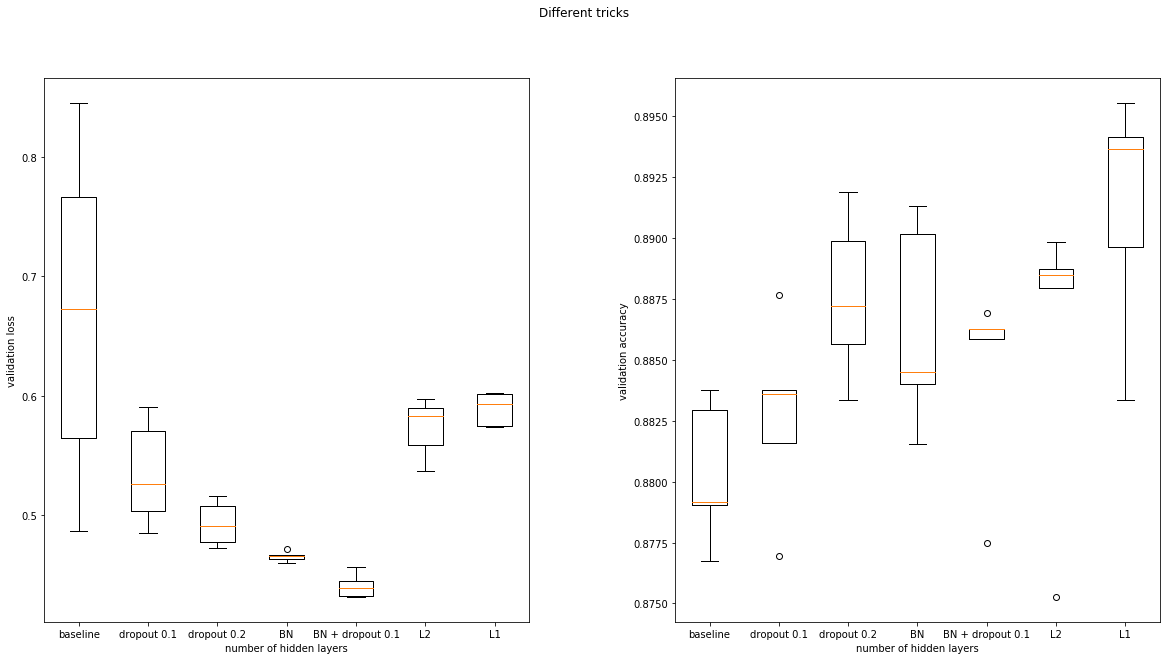

<Figure size 720x432 with 0 Axes>

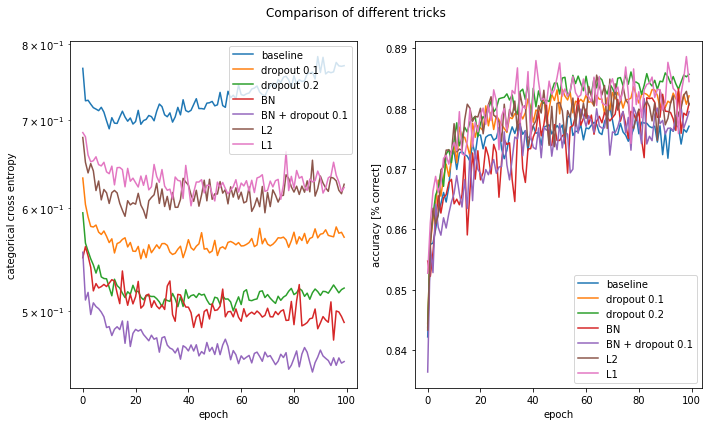

In [46]:
print_results(histories, losses, accuracies)

We can make multiple observations on these results. We plotted both a summary boxplot in terms of loss and accuracy, and the training curves of validation loss and accuracy. The training curves seem very noisy as compared to the previous tests, especially as they are averaged over 5 runs ; however this is only due to the scale of the axis. They are anyway difficult to exploit, so we will found our discussion more on the boxplots.

First of all, all models outperform the baseline. We can also clearly observe the effect of adding regularization to the model when comparing batch normalization (denoted as BN) with and without dropout on the accuracy boxplot : the mean accuracy is around the same, but the variance is drastically reduced by the dropout.

It is hard to tell exactly which model should be deemed as the best. Regarding accuracy, L1 and L2 regularization offer the best results but are amongst the worst in terms of loss. Moreover, we obtain a better accuracy in average with L1 regularization but also more variance. We kept L1 regularization as the best model in the following ; but actually we will see that it will be largely outperformed, so the choice of the best model here does not really matter.

In [61]:
histories_keep1 = dict(histories)
losses_keep1 = dict(losses)
accuracies_keep1 = dict(accuracies)

#### 4 hidden layers

In [74]:
histories4 = {}
losses4 = {}
accuracies4 = {}

#Baseline
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, 'baseline', histories4, losses4, accuracies4)

# Dropout on the hidden layers only
for d in (0.1, 0.2):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(256,)))
    model.add(Dropout(d))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    test_model(model, 'dropout '+str(d), histories4, losses4, accuracies4)

# Only batch normalization
from keras.layers import BatchNormalization

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,)))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, 'BN', histories4, losses4, accuracies4)

# Batch normalization + dropout
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, 'BN + dropout 0.1', histories4, losses4, accuracies4)

#only regularizers: L2
from keras import regularizers
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,), kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, "L2", histories4, losses4, accuracies4)


#only regularizers: L1
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,), kernel_regularizer=regularizers.l1(1e-4)))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
test_model(model, "L1", histories4, losses4, accuracies4)

### baseline ###
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_197 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_198 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_199 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_200 (Dense)            (None, 5)                 505       
Total params: 56,505
Trainable params: 56,505
Non-trainable params: 0
_________________________________________________________________
Validation loss: 0.930 ± 0.302
Accuracy: 0.873 ± 0.004



### dropout 0.1 ###
___________________________________________

### L1 ###
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_227 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_228 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_229 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_230 (Dense)            (None, 5)                 505       
Total params: 56,505
Trainable params: 56,505
Non-trainable params: 0
_________________________________________________________________
Validation loss: 0.518 ± 0.010
Accuracy: 0.892 ± 0.002





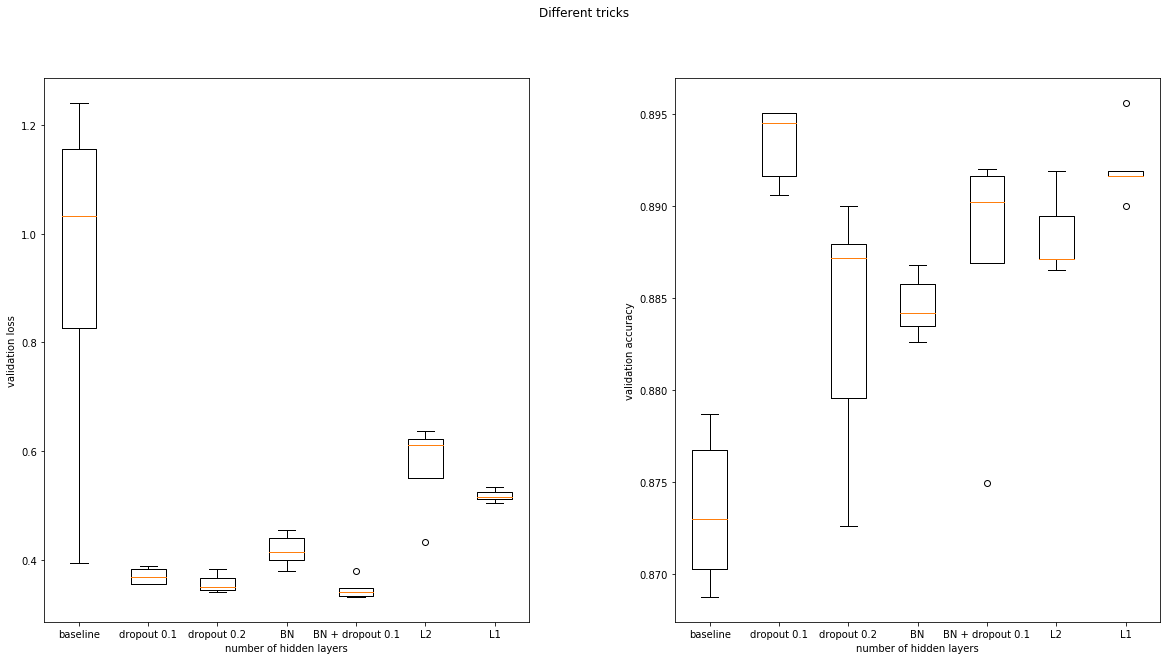

<Figure size 720x432 with 0 Axes>

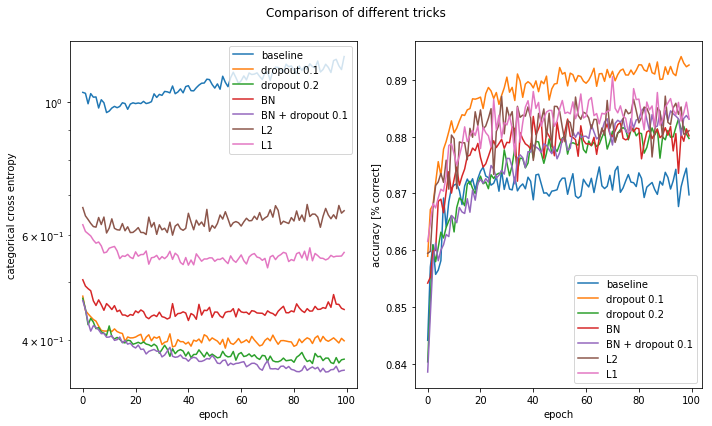

In [71]:
print_results(histories4, losses4, accuracies4)

All the models outperform again the baseline. This time we chose to keep the dropout model (with a dropout rate of 0.1). The L1-regularized model seemed also a good choice with a low variance, but if consider the two outliers it displays on the accuracy boxplot (which are significant among 5 runs), its variance is actually comparable to the dropout model, which displays a better validation loss and a slightly better accuracy.

#### Comparisons

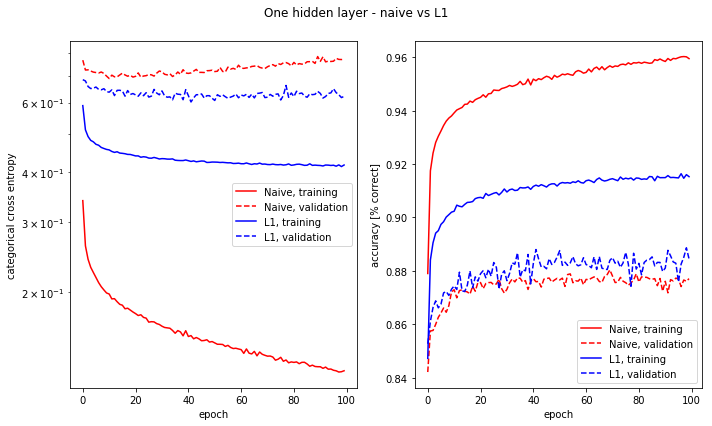

In [91]:
# Baseline 1 layer vs best performing 1 layer
baseline = histories_keep1["baseline"]
best = histories_keep1["L1"]

fig, ax1, ax2 = prepare_standardplot("One hidden layer - naive vs L1", 'epoch')
ax1.plot(baseline.history['loss'], label = "Naive, training", c='r')
ax1.plot(baseline.history['val_loss'], label = "Naive, validation", c='r', linestyle='--')
ax1.plot(best.history['loss'], label = "L1, training", c='b')
ax1.plot(best.history['val_loss'], label = "L1, validation", c='b', linestyle='--')
ax2.plot(baseline.history['acc'], label = "Naive, training", c='r')
ax2.plot(baseline.history['val_acc'], label = "Naive, validation", c='r', linestyle='--')
ax2.plot(best.history['acc'], label = "L1, training", c='b')
ax2.plot(best.history['val_acc'], label = "L1, validation", c='b', linestyle='--')
finalize_standardplot(fig, ax1, ax2)

The curves show that our regularized model only slightly outperforms the baseline (as compared with the following curves for a 4-hidden-layers model). This is probably due to the fact that with only one hidden layer, the model lacks flexibility, an the main concern is not overfitting. Regularization can maybe improve a bit the model's variance, but we still are underfitting the data at that point.

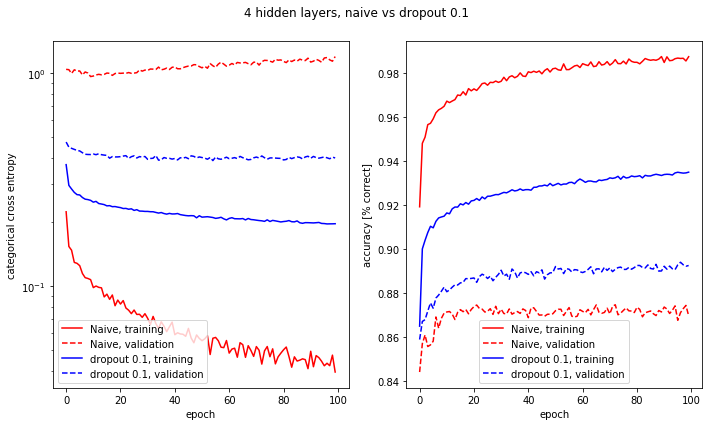

In [92]:
# Best 4 layers vs baseline
baseline = histories_keep4["baseline"]
best = histories_keep4["dropout 0.1"]

fig, ax1, ax2 = prepare_standardplot("4 hidden layers, naive vs dropout 0.1", 'epoch')
ax1.plot(baseline.history['loss'], label = "Naive, training", c='r')
ax1.plot(baseline.history['val_loss'], label = "Naive, validation", c='r', linestyle='--')
ax1.plot(best.history['loss'], label = "dropout 0.1, training", c='b')
ax1.plot(best.history['val_loss'], label = "dropout 0.1, validation", c='b', linestyle='--')
ax2.plot(baseline.history['acc'], label = "Naive, training", c='r')
ax2.plot(baseline.history['val_acc'], label = "Naive, validation", c='r', linestyle='--')
ax2.plot(best.history['acc'], label = "dropout 0.1, training", c='b')
ax2.plot(best.history['val_acc'], label = "dropout 0.1, validation", c='b', linestyle='--')
finalize_standardplot(fig, ax1, ax2)

With 4 layers, we can more clearly see the benefits of regularizaion, as the regularized model outperforms the baseline by a comfortable margin.

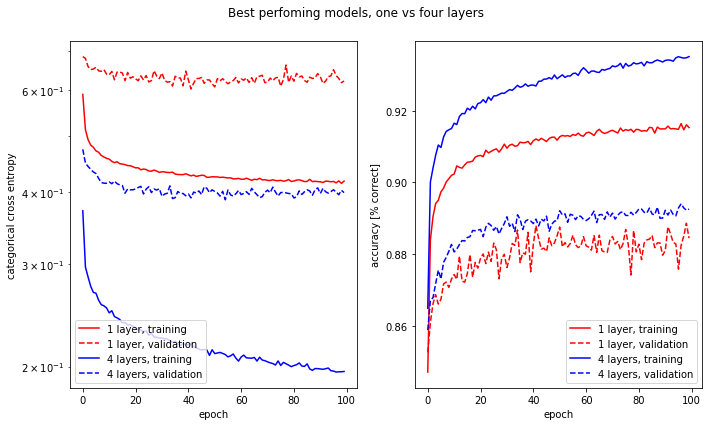

In [93]:
# Two best performing
one = histories_keep1["L1"]
four = histories_keep4["dropout 0.1"]

fig, ax1, ax2 = prepare_standardplot("Best perfoming models, one vs four layers", 'epoch')
ax1.plot(one.history['loss'], label = "1 layer, training", c='r')
ax1.plot(one.history['val_loss'], label = "1 layer, validation", c='r', linestyle='--')
ax1.plot(four.history['loss'], label = "4 layers, training", c='b')
ax1.plot(four.history['val_loss'], label = "4 layers, validation", c='b', linestyle='--')
ax2.plot(one.history['acc'], label = "1 layer, training", c='r')
ax2.plot(one.history['val_acc'], label = "1 layer, validation", c='r', linestyle='--')
ax2.plot(four.history['acc'], label = "4 layers, training", c='b')
ax2.plot(four.history['val_acc'], label = "4 layers, validation", c='b', linestyle='--')
finalize_standardplot(fig, ax1, ax2)

By observing these curves, and in particular by seeing that the 4-hidden-layers regularized model outperforms our best 1-layer model, both in average performance and in stability, we can confirm our intuition of exercise 5, where adding more hidden layers had not improved on the performance : with proper regularization, adding more hidden layers allowed us this time to improve significantly on the results.

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In the following, we will try 4 different CNN models:
- a simple CNN with only one convolution - max pooling step, and no regularization
- the same model with dropout
- a deeper CNN with two steps of convolution - max pooling without regularization
- the same model with dropout

In [83]:
#First we have to reshape the whole dataset
if keras.backend.image_data_format() == 'channels_first':
    x_train_cnn = x_train.reshape((x_train.shape[0], 1, 16, 16))
    x_test_cnn = x_test.reshape((x_test.shape[0], 1, 16, 16))
    input_shape = (1,16,16)
elif keras.backend.image_data_format() == 'channels_last':
    x_train_cnn = x_train.reshape((x_train.shape[0], 16, 16, 1))
    x_test_cnn = x_test.reshape((x_test.shape[0], 16, 16, 1))
    input_shape = (16,16,1)

In [84]:
print(x_train_cnn.shape)

(40427, 16, 16, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 201,797
Trainable params: 201,797
Non-trainable params: 0
_________________________________________________________________
(0.26676246864528247, 0.9268144753247759)


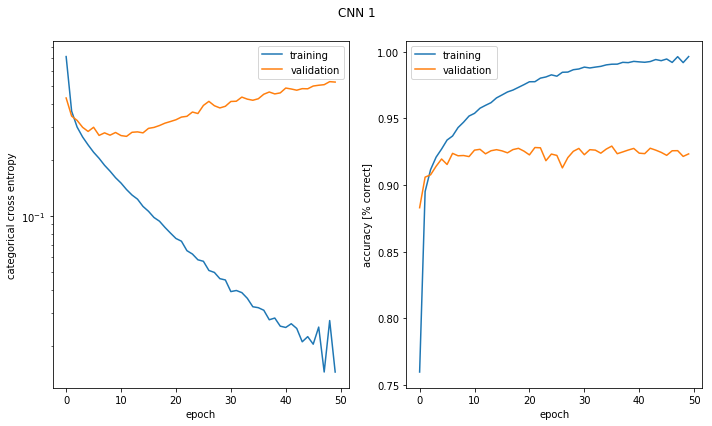

In [95]:
#Basic CNN: convolution, max-pooling, dense hidden layer, output layer
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn1 = fit_model(model, x_train_cnn, y_train, epochs=50, verbose=1, validation_data=(x_test_cnn, y_test))
score_cnn1 = bestValidationScore(history_cnn1)
print(score_cnn1)
plot_history(history_cnn1, title="CNN 1")
model_cnn1 = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               200832    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total para

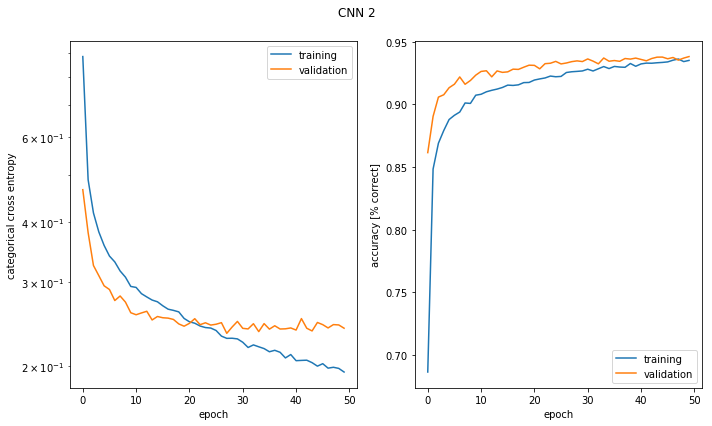

In [13]:
#Adding some dropout
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn2 = fit_model(model, x_train_cnn, y_train, epochs=50, verbose=1, validation_data=(x_test_cnn, y_test))
score_cnn2 = bestValidationScore(history_cnn2)
print(score_cnn2)
plot_history(history_cnn2, title="CNN 2")
model_cnn2 = model

By comparing these first two networks, we can make two conclusions :
- The effect of dropout is once again clearly visible, the validation curves are much closer to the training curves with regularization. It is also interesting to see how the validation accuracy curve is above the training curve, due to the fact that the network does not use all his neurons during training.
- Comparing the figures of mean accuracy and loss with the results of the previous exercises, we can already see that we improved significantly on our model performance.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total para

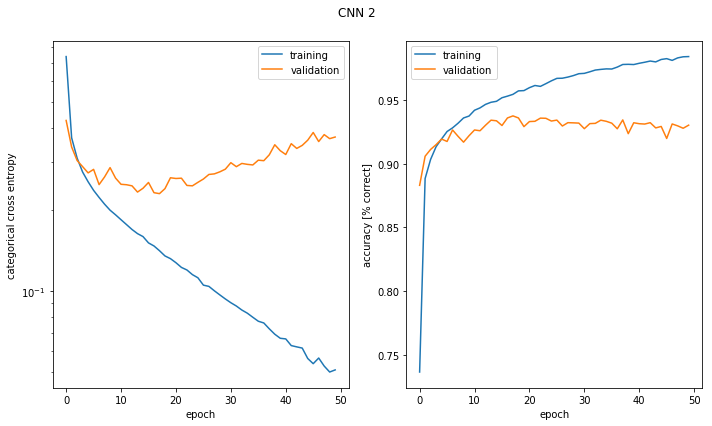

In [14]:
#One additional convolution + max pooling layer, without dropout
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn3 = fit_model(model, x_train_cnn, y_train, epochs=50, verbose=1, validation_data=(x_test_cnn, y_test))
score_cnn3 = bestValidationScore(history_cnn3)
print(score_cnn3)
plot_history(history_cnn3, title="CNN 2")
model_cnn2 = model

In [1]:
#Same, with dropout
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn4 = fit_model(model, x_train_cnn, y_train, epochs=50, verbose=1, validation_data=(x_test_cnn, y_test))
score_cnn4 = bestValidationScore(history_cnn4)
print(score_cnn4)
model_cnn4 = model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_231 (Dense)            (None, 128)               16512     
_________

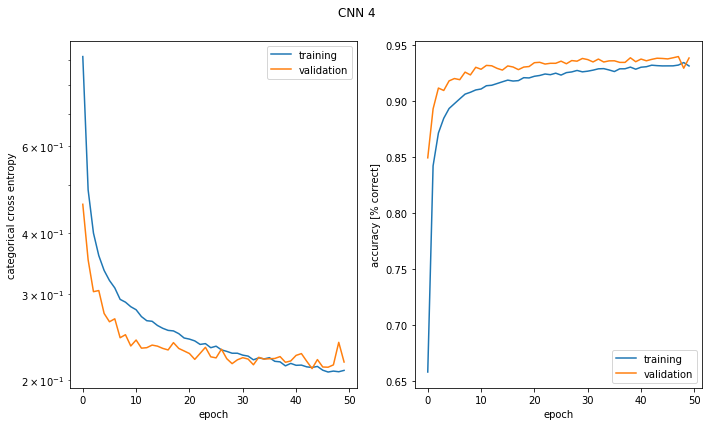

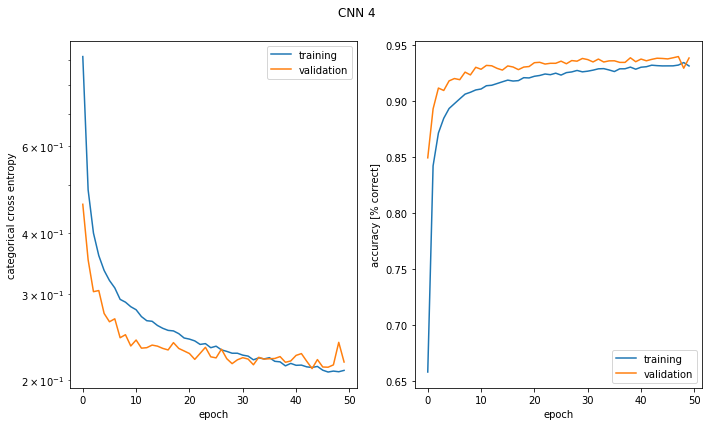

In [96]:
plot_history(history_cnn4, title="CNN 4")

#### Comparison with previous best model

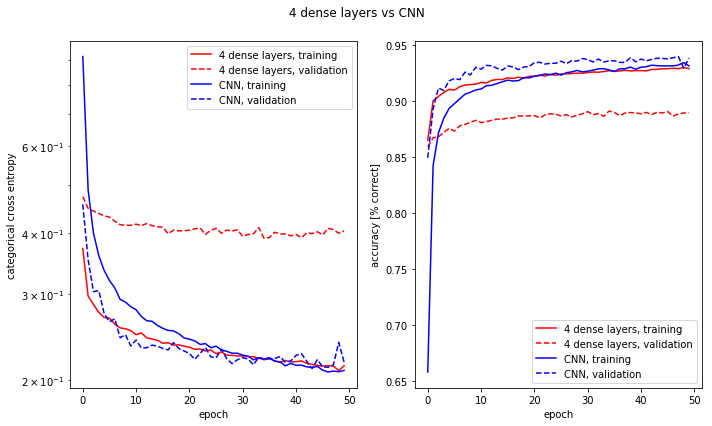

In [98]:
old = histories_keep4["dropout 0.1"]
cnn = history_cnn4

fig, ax1, ax2 = prepare_standardplot("4 dense layers vs CNN", 'epoch')
ax1.plot(old.history['loss'][:50], label = "4 dense layers, training", c='r')
ax1.plot(old.history['val_loss'][:50], label = "4 dense layers, validation", c='r', linestyle='--')
ax1.plot(cnn.history['loss'], label = "CNN, training", c='b')
ax1.plot(cnn.history['val_loss'], label = "CNN, validation", c='b', linestyle='--')
ax2.plot(old.history['acc'][:50], label = "4 dense layers, training", c='r')
ax2.plot(old.history['val_acc'][:50], label = "4 dense layers, validation", c='r', linestyle='--')
ax2.plot(cnn.history['acc'], label = "CNN, training", c='b')
ax2.plot(cnn.history['val_acc'], label = "CNN, validation", c='b', linestyle='--')
finalize_standardplot(fig, ax1, ax2)

These curves confirm what the figures were already telling : CNN models clearly outperform our previous dense networks, which demonstrates the fact that, by taking into account the structure of the data they are really, better suited for this kind of inputs.